In [76]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Loading Dependencies**

In [77]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import random


**Explore and Labeling**

In [78]:
def get_files_in_var(directry):
  var = os.listdir(f"{directry}")
  print(var[0:5])
  print(var[-5:])
  print(len(var))

In [79]:
normal_x_ray_files = get_files_in_var("/kaggle/input/labeled-chest-xray-images/chest_xray/train/NORMAL")
pneu_x_ray_files = get_files_in_var("/kaggle/input/labeled-chest-xray-images/chest_xray/train/PNEUMONIA")

# Oversample the normal class
#oversampled_normal_files = random.choices(normal_x_ray_files, k=len(pneu_x_ray_files))
under_sampled_files = random.choices(pneu_x_ray_files,k=len(normal_x_ray_files))
# Create the DataFrame
image_paths = []
labels = []

# Add the oversampled normal images
for filename in normal_x_ray_files:
    image_paths.append(os.path.join("/kaggle/input/labeled-chest-xray-images/chest_xray/train/NORMAL", filename))
    labels.append("NORMAL")

# Add the pneumonia images
for filename in under_sampled_files:
    image_paths.append(os.path.join("/kaggle/input/labeled-chest-xray-images/chest_xray/train/PNEUMONIA", filename))
    labels.append("PNEUMONIA")

df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

# Shuffle the DataFrame
df = df.sample(frac=1).reset_index(drop=True)

print("Number of NORMAL images after oversampling:", len(normal_x_ray_files))
print("Number of PNEUMONIA images:", len(under_sampled_files))
display(df.head())
print(len(df))

['NORMAL-705219-0001.jpeg', 'NORMAL-9031828-0001.jpeg', 'NORMAL-9211217-0001.jpeg', 'NORMAL-8050432-0001.jpeg', 'NORMAL-6897353-0001.jpeg']
['NORMAL-9020082-0003.jpeg', 'NORMAL-7835976-0001.jpeg', 'NORMAL-170867-0001.jpeg', 'NORMAL-9486523-0001.jpeg', 'NORMAL-1456124-0001.jpeg']
1349
['VIRUS-4670779-0001.jpeg', 'BACTERIA-5132924-0001.jpeg', 'BACTERIA-1777631-0001.jpeg', 'BACTERIA-7392124-0001.jpeg', 'BACTERIA-9072988-0007.jpeg']
['BACTERIA-3852742-0001.jpeg', 'BACTERIA-4313165-0003.jpeg', 'BACTERIA-6518955-0001.jpeg', 'BACTERIA-3076396-0001.jpeg', 'BACTERIA-7630183-0003.jpeg']
3883
Number of NORMAL images after oversampling: 1349
Number of PNEUMONIA images: 1349


,image_path,label
0,/kaggle/input/labeled-chest-xray-images/chest_...,NORMAL
1,/kaggle/input/labeled-chest-xray-images/chest_...,PNEUMONIA
2,/kaggle/input/labeled-chest-xray-images/chest_...,PNEUMONIA
3,/kaggle/input/labeled-chest-xray-images/chest_...,PNEUMONIA
4,/kaggle/input/labeled-chest-xray-images/chest_...,PNEUMONIA


2698


**Check_undersampled_**

In [80]:
df['label'] = df['label'].apply(lambda x: 1 if x=='PNEUMONIA' else 0)
display(df.head())
print(df['label'].value_counts())

,image_path,label
0,/kaggle/input/labeled-chest-xray-images/chest_...,0
1,/kaggle/input/labeled-chest-xray-images/chest_...,1
2,/kaggle/input/labeled-chest-xray-images/chest_...,1
3,/kaggle/input/labeled-chest-xray-images/chest_...,1
4,/kaggle/input/labeled-chest-xray-images/chest_...,1


label
0    1349
1    1349
Name: count, dtype: int64


In [81]:
df["image_path"][0]

'/kaggle/input/labeled-chest-xray-images/chest_xray/train/NORMAL/NORMAL-8106741-0001.jpeg'

**Exploring_images and_looking for Difference in images**

[291, 2630, 1120, 1599, 955, 995, 1126, 1513, 2264, 1498]


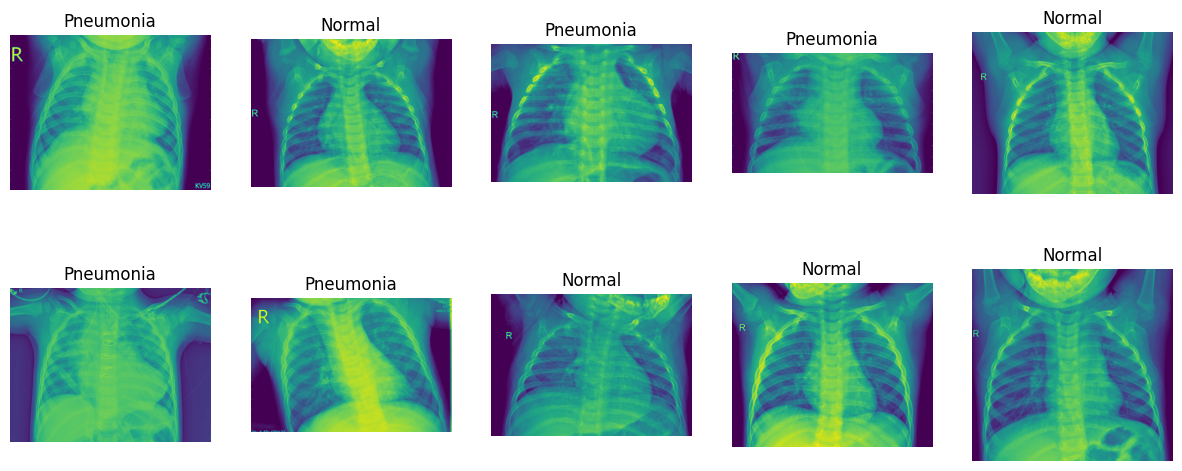

In [82]:
random_samples = random.sample(range(len(df)), 10)
print(random_samples)

plt.figure(figsize=(15, 6))
for i, sample_index in enumerate(random_samples):
    plt.subplot(2, 5, i + 1)
    img = mpimg.imread(df["image_path"][sample_index])
    plt.imshow(img)
    if df["label"][sample_index] == 0:
        plt.title("Normal")
    else:
        plt.title("Pneumonia")
    plt.axis("off")

Original mode of image at index 1200: L
New mode of image at index 1200: RGB
Original mode of image at index 2600: L
New mode of image at index 2600: RGB


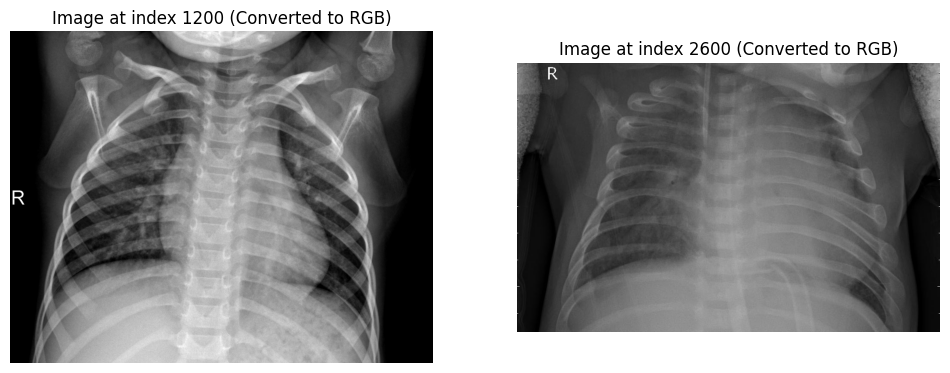

In [83]:
def convert_and_show(index, subplot_index):
    image_path = df["image_path"][index]
    with Image.open(image_path) as img:
        print(f"Original mode of image at index {index}: {img.mode}")
        rgb_img = img.convert('RGB')
        print(f"New mode of image at index {index}: {rgb_img.mode}")

        plt.subplot(1, 2, subplot_index)
        plt.imshow(rgb_img)
        plt.title(f"Image at index {index} (Converted to RGB)")
        plt.axis("off")

plt.figure(figsize=(12, 6))
convert_and_show(1200, 1)
convert_and_show(2600, 2)
plt.show()

**Preprocessing_train**

In [84]:
def preprocess_data(df):
  data = []
  labels  = []
  for i in range(len(df)):
    img = Image.open(df["image_path"][i])
    img = img.resize((256,256))
    img = img.convert("RGB")
    img = np.array(img)
    data.append(img)
    labels.append(df["label"][i])
  return data, labels

data , labels = preprocess_data(df)

In [85]:
len(data) == len(labels)

True

In [86]:
type(data[0])

numpy.ndarray

In [87]:
type(labels[0])

numpy.int64

In [88]:
data[0].shape

(256, 256, 3)

In [89]:
x = np.array(data)
y = np.array(labels)
print(type(x),type(y))
print("Shape x :", x.shape, "Shape y :",y.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Shape x : (2698, 256, 256, 3) Shape y : (2698,)


In [90]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

print("x_train shape:", x_train.shape)
print("x_val shape:", x_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

x_train shape: (2158, 256, 256, 3)
x_val shape: (540, 256, 256, 3)
y_train shape: (2158,)
y_val shape: (540,)


In [91]:
x_train_scaled = x_train / 255
x_val_scaled = x_val / 255

In [92]:
x_val_scaled[0]

array([[[0.21568627, 0.21568627, 0.21568627],
        [0.21960784, 0.21960784, 0.21960784],
        [0.22745098, 0.22745098, 0.22745098],
        ...,
        [0.48627451, 0.48627451, 0.48627451],
        [0.50196078, 0.50196078, 0.50196078],
        [0.39607843, 0.39607843, 0.39607843]],

       [[0.25882353, 0.25882353, 0.25882353],
        [0.26666667, 0.26666667, 0.26666667],
        [0.27058824, 0.27058824, 0.27058824],
        ...,
        [0.44705882, 0.44705882, 0.44705882],
        [0.4627451 , 0.4627451 , 0.4627451 ],
        [0.38823529, 0.38823529, 0.38823529]],

       [[0.30196078, 0.30196078, 0.30196078],
        [0.30196078, 0.30196078, 0.30196078],
        [0.30196078, 0.30196078, 0.30196078],
        ...,
        [0.45882353, 0.45882353, 0.45882353],
        [0.46666667, 0.46666667, 0.46666667],
        [0.41568627, 0.41568627, 0.41568627]],

       ...,

       [[0.01960784, 0.01960784, 0.01960784],
        [0.01176471, 0.01176471, 0.01176471],
        [0.02352941, 0

In [93]:
x_train_scaled[12]

array([[[0.03529412, 0.03529412, 0.03529412],
        [0.03921569, 0.03921569, 0.03921569],
        [0.04313725, 0.04313725, 0.04313725],
        ...,
        [0.01960784, 0.01960784, 0.01960784],
        [0.01176471, 0.01176471, 0.01176471],
        [0.00784314, 0.00784314, 0.00784314]],

       [[0.03529412, 0.03529412, 0.03529412],
        [0.03921569, 0.03921569, 0.03921569],
        [0.04313725, 0.04313725, 0.04313725],
        ...,
        [0.01960784, 0.01960784, 0.01960784],
        [0.01568627, 0.01568627, 0.01568627],
        [0.01176471, 0.01176471, 0.01176471]],

       [[0.03529412, 0.03529412, 0.03529412],
        [0.03921569, 0.03921569, 0.03921569],
        [0.04705882, 0.04705882, 0.04705882],
        ...,
        [0.02352941, 0.02352941, 0.02352941],
        [0.01960784, 0.01960784, 0.01960784],
        [0.01568627, 0.01568627, 0.01568627]],

       ...,

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0

**Model Layers,Compilation and Training**

In [94]:
num_class = 2
model = keras.Sequential()
model.add(keras.layers.Conv2D(32,kernel_size=(3,3),activation="relu",input_shape=(256,256,3)))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Conv2D(64,kernel_size=(3,3),activation="relu"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128,activation="relu"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(64,activation="relu"))
model.add(keras.layers.Dropout(0.8))
model.add(keras.layers.Dense(num_class,activation="sigmoid"))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [95]:
model.compile(
    optimizer="adam",
    loss = "sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [96]:
history = model.fit(
    x_train_scaled, y_train,
    validation_data=(x_val_scaled, y_val),
    epochs=5
)

Epoch 1/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - accuracy: 0.5329 - loss: 3.1717 - val_accuracy: 0.8463 - val_loss: 0.4606
Epoch 2/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.8330 - loss: 0.4246 - val_accuracy: 0.9185 - val_loss: 0.2546
Epoch 3/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9037 - loss: 0.2729 - val_accuracy: 0.9500 - val_loss: 0.1594
Epoch 4/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9478 - loss: 0.1874 - val_accuracy: 0.9500 - val_loss: 0.1596
Epoch 5/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9551 - loss: 0.1524 - val_accuracy: 0.9630 - val_loss: 0.1395


**Graph Loss vs Accuracy**

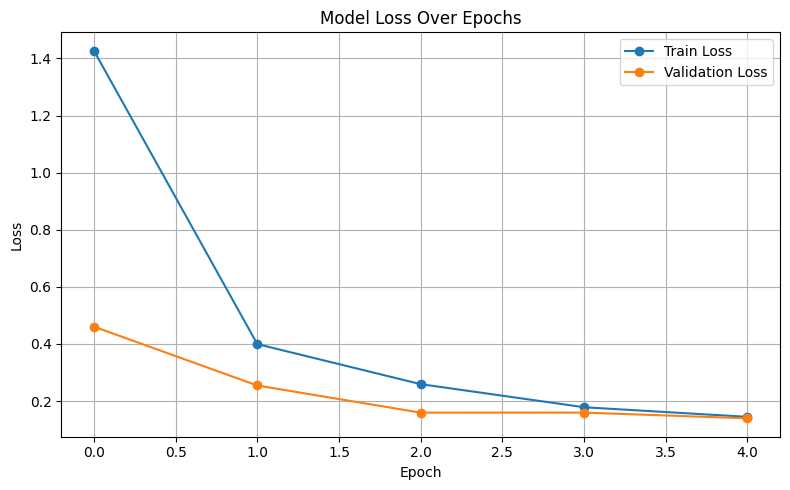

In [109]:

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Hardcoded Test_data_labeling**
--
--> Make a finction and you can do the same 

In [97]:

def get_files_in_var(directry):
  var = os.listdir(f"{directry}")
  print(var[0:5])
  print(var[-5:])
  print(len(var))
  return var

normal_x_ray_files = get_files_in_var("/kaggle/input/labeled-chest-xray-images/chest_xray/test/NORMAL")
pneu_x_ray_files = get_files_in_var("/kaggle/input/labeled-chest-xray-images/chest_xray/test/PNEUMONIA")
under_sampled_files = random.choices(pneu_x_ray_files,k=len(normal_x_ray_files))
image_paths1 = []
labels1 = []

for filename in normal_x_ray_files:
    image_paths1.append(os.path.join("/kaggle/input/labeled-chest-xray-images/chest_xray/test/NORMAL", filename))
    labels1.append("NORMAL")


for filename in under_sampled_files:
    image_paths1.append(os.path.join("/kaggle/input/labeled-chest-xray-images/chest_xray/test/PNEUMONIA", filename))
    labels1.append("PNEUMONIA")

df1 = pd.DataFrame({
    'image_path': image_paths1,
    'label': labels1
})

# Shuffle the DataFrame
df1 = df1.sample(frac=1).reset_index(drop=True)

print("Number of NORMAL images :", len(normal_x_ray_files))
print("Number of PNEUMONIA images:", len(pneu_x_ray_files))
print(len(df1))
df1.head()


['NORMAL-6293151-0001.jpeg', 'NORMAL-4315572-0001.jpeg', 'NORMAL-5893138-0001.jpeg', 'NORMAL-7225301-0001.jpeg', 'NORMAL-1627110-0001.jpeg']
['NORMAL-520267-0001.jpeg', 'NORMAL-3686746-0001.jpeg', 'NORMAL-6410283-0001.jpeg', 'NORMAL-1931427-0001.jpeg', 'NORMAL-7738170-0001.jpeg']
234
['BACTERIA-9364007-0003.jpeg', 'BACTERIA-1135262-0001.jpeg', 'VIRUS-9476607-0001.jpeg', 'VIRUS-2831144-0001.jpeg', 'BACTERIA-7720431-0003.jpeg']
['BACTERIA-5754167-0001.jpeg', 'BACTERIA-8983865-0002.jpeg', 'VIRUS-6831597-0001.jpeg', 'VIRUS-2040583-0002.jpeg', 'BACTERIA-4269599-0007.jpeg']
390
Number of NORMAL images : 234
Number of PNEUMONIA images: 390
468


,image_path,label
0,/kaggle/input/labeled-chest-xray-images/chest_...,PNEUMONIA
1,/kaggle/input/labeled-chest-xray-images/chest_...,PNEUMONIA
2,/kaggle/input/labeled-chest-xray-images/chest_...,PNEUMONIA
3,/kaggle/input/labeled-chest-xray-images/chest_...,PNEUMONIA
4,/kaggle/input/labeled-chest-xray-images/chest_...,NORMAL


In [98]:
df1["label"] = df1["label"].apply(lambda x : 0 if x == "NORMAL" else 1) 

In [99]:
df1.head()

,image_path,label
0,/kaggle/input/labeled-chest-xray-images/chest_...,1
1,/kaggle/input/labeled-chest-xray-images/chest_...,1
2,/kaggle/input/labeled-chest-xray-images/chest_...,1
3,/kaggle/input/labeled-chest-xray-images/chest_...,1
4,/kaggle/input/labeled-chest-xray-images/chest_...,0


**Hardcoded_preprocessing_for_test**

In [100]:
def preprocess_data_test(df1):
  data1 = []
  labels1  = []
  for i in range(len(df1)):
    img = Image.open(df1["image_path"][i])
    img = img.resize((256,256))
    img = img.convert("RGB")
    img = np.array(img)
    data1.append(img)
    labels1.append(df1["label"][i])
  return data1, labels1

data1 , labels1 = preprocess_data_test(df1)

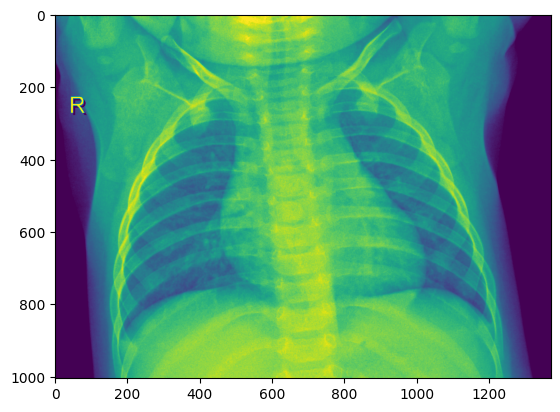

In [101]:
img = Image.open(df["image_path"][0])
plt.imshow(img)
#1 <-- pneumonia

In [102]:
X = np.array(data1)
print(X.shape)
X_scaled = X / 255
X_scaled[0]

(468, 256, 256, 3)


array([[[0.02352941, 0.02352941, 0.02352941],
        [0.02352941, 0.02352941, 0.02352941],
        [0.02352941, 0.02352941, 0.02352941],
        ...,
        [0.75294118, 0.75294118, 0.75294118],
        [0.72941176, 0.72941176, 0.72941176],
        [0.76862745, 0.76862745, 0.76862745]],

       [[0.02352941, 0.02352941, 0.02352941],
        [0.02352941, 0.02352941, 0.02352941],
        [0.02352941, 0.02352941, 0.02352941],
        ...,
        [0.7372549 , 0.7372549 , 0.7372549 ],
        [0.74901961, 0.74901961, 0.74901961],
        [0.78039216, 0.78039216, 0.78039216]],

       [[0.02352941, 0.02352941, 0.02352941],
        [0.02352941, 0.02352941, 0.02352941],
        [0.02352941, 0.02352941, 0.02352941],
        ...,
        [0.74509804, 0.74509804, 0.74509804],
        [0.74509804, 0.74509804, 0.74509804],
        [0.81176471, 0.81176471, 0.81176471]],

       ...,

       [[0.0627451 , 0.0627451 , 0.0627451 ],
        [0.0627451 , 0.0627451 , 0.0627451 ],
        [0.05882353, 0

In [103]:
df1.head(15)

,image_path,label
0,/kaggle/input/labeled-chest-xray-images/chest_...,1
1,/kaggle/input/labeled-chest-xray-images/chest_...,1
2,/kaggle/input/labeled-chest-xray-images/chest_...,1
3,/kaggle/input/labeled-chest-xray-images/chest_...,1
4,/kaggle/input/labeled-chest-xray-images/chest_...,0
5,/kaggle/input/labeled-chest-xray-images/chest_...,1
6,/kaggle/input/labeled-chest-xray-images/chest_...,0
7,/kaggle/input/labeled-chest-xray-images/chest_...,1
8,/kaggle/input/labeled-chest-xray-images/chest_...,0
9,/kaggle/input/labeled-chest-xray-images/chest_...,0


**Model Evaluation**

In [104]:
y_pred = model.predict(X_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


In [105]:
y_true = np.array(labels1)

accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Accuracy: {accuracy:.4f}")

print(classification_report(y_true, y_pred_classes))


print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))


Accuracy: 0.8291
              precision    recall  f1-score   support

           0       0.95      0.70      0.80       234
           1       0.76      0.96      0.85       234

    accuracy                           0.83       468
   macro avg       0.85      0.83      0.83       468
weighted avg       0.85      0.83      0.83       468


Confusion Matrix:
[[163  71]
 [  9 225]]


**Confusion_matrix**

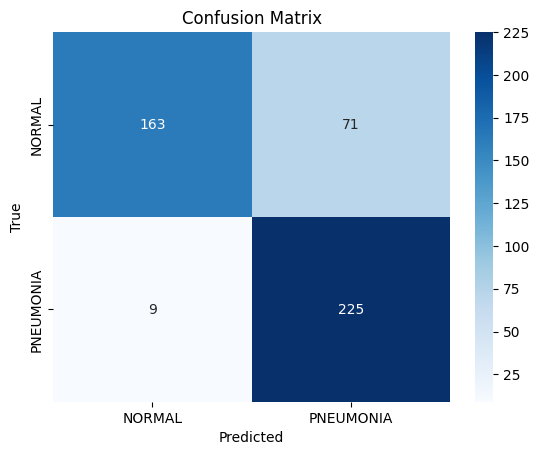

In [106]:
import seaborn as sns

cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["NORMAL", "PNEUMONIA"], yticklabels=["NORMAL", "PNEUMONIA"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [108]:
(163+225)/(71+225+9+163)*100

82.90598290598291

**Saving Model**

In [111]:
model.save("chest_x_raymodel.h5")
# from tensorflow.keras.models import load_model
# model = load_model("my_model.h5")  
